In [14]:
# Import required packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/train_data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/train_data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/train_data/noisy_labels.csv', delimiter=',', dtype="int8")

In [3]:
clean_labels.shape

(10000,)

In [5]:
noisy_labels.shape

(50000,)

In [6]:
imgs.shape

(50000, 32, 32, 3)

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


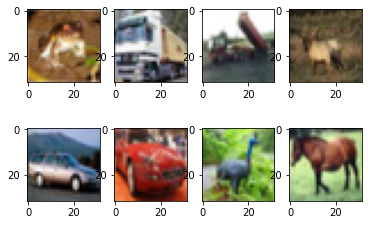

In [7]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [8]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [9]:
feature_mtx.shape

(50000, 15)

In [10]:
target_vec

array([3., 5., 9., ..., 9., 1., 1.])

In [11]:
bins

array([  0.,  51., 102., 153., 204., 255.])

In [12]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [13]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [13]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

X_train, X_valid, y_train, y_valid = train_test_split(imgs[10000:], noisy_labels[10000:], test_size=0.2, random_state=42)

X_train = np.array(X_train) / 255
X_valid = np.array(X_valid) / 255

In [15]:
### Basic CNN Model ###

model1 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (32, 32, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(10)
])

model1.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = "adam", metrics = ["accuracy"])

history1 = model1.fit(X_train, y_train, epochs = 10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1000/1000 [==============================] - 23s 23ms/step - loss: 2.2927 - accuracy: 0.1234 - val_loss: 2.2596 - val_accuracy: 0.1688
Epoch 2/10
1000/1000 [==============================] - 22s 22ms/step - loss: 2.2530 - accuracy: 0.1757 - val_loss: 2.2463 - val_accuracy: 0.1782
Epoch 3/10
1000/1000 [==============================] - 22s 22ms/step - loss: 2.2283 - accuracy: 0.1979 - val_loss: 2.2408 - val_accuracy: 0.1918
Epoch 4/10
1000/1000 [==============================] - 23s 23ms/step - loss: 2.2081 - accuracy: 0.2188 - val_loss: 2.2335 - val_accuracy: 0.2041
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: 2.1870 - accuracy: 0.2254 - val_loss: 2.2395 - val_accuracy: 0.2049
Epoch 6/10
1000/1000 [==============================] - 22s 22ms/step - loss: 2.1564 - accuracy: 0.2434 - val_loss: 2.2483 - val_accuracy: 0.2005
Epoch 7/10
1000/1000 [==============================] - 22s 22ms/step - loss: 2.1256 - accuracy: 0.2577 - val_loss: 2.2605 -

In [16]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    X_test = np.array(image)/255
    return np.argmax(model1.predict(X_test))

def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for i in range(len(test_imgs)):
        y_pred.append(model(test_imgs[i:i+1]))
    print(classification_report(y_true, y_pred))

In [17]:
n_test = 10000
test_labels = clean_labels
test_imgs = imgs[:10000]
evaluation(model_I, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.42      0.53      0.47      1005
           1       0.37      0.63      0.47       974
           2       0.30      0.28      0.29      1032
           3       0.29      0.29      0.29      1016
           4       0.35      0.33      0.34       999
           5       0.32      0.21      0.25       937
           6       0.46      0.40      0.43      1030
           7       0.49      0.43      0.46      1001
           8       0.48      0.42      0.45      1025
           9       0.47      0.43      0.45       981

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.39     10000
weighted avg       0.40      0.39      0.39     10000



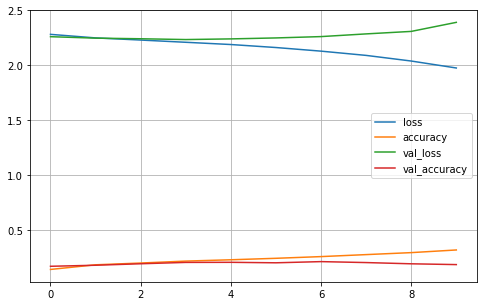

In [18]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)

### 2.3. Model II

#### Label Cleaning

In [15]:
clean = keras.utils.to_categorical(clean_labels)
noise = keras.utils.to_categorical(noisy_labels[0:10000])
imgs_clean = imgs[:10000]/255

In [20]:
# In paper, it is L1 loss, for convienience, we will use MSE, similar with L1 loss
loss_fn = keras.losses.MeanSquaredError(reduction='none')

# By the paper, we have two 
input_img = keras.layers.Input(shape=(32, 32, 3))
input_noise = keras.layers.Input(shape=(10))

# here is model 1, this model is use only for coding
base = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape = (32, 32, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(10)])

# From the paper, we need output after model1 and the ReLU training
x = base(input_img)
x = keras.layers.Dense(256)(x)

y = keras.layers.Dense(10)(input_noise)

# train together
z = keras.layers.Concatenate(axis=1)([y, x])
z = keras.layers.Dense(256, activation = 'relu')(z)
z = keras.layers.BatchNormalization()(z)

output = keras.layers.Dense(10, activation = 'softmax')(z)

model_label = keras.models.Model([input_img, input_noise], output)
model_label.compile(loss=loss_fn, metrics=['acc'], optimizer=keras.optimizers.RMSprop(0.001))

model_label.fit([imgs_clean, noise], clean, batch_size = 16, epochs = 15)

2022-03-22 18:18:59.667924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0794 - acc: 0.3655
Epoch 2/15
625/625 [==============================] - 8s 13ms/step - loss: 0.0618 - acc: 0.5330
Epoch 3/15
625/625 [==============================] - 8s 13ms/step - loss: 0.0545 - acc: 0.5915
Epoch 4/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0501 - acc: 0.6272
Epoch 5/15
625/625 [==============================] - 8s 13ms/step - loss: 0.0449 - acc: 0.6703
Epoch 6/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0394 - acc: 0.7144
Epoch 7/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0362 - acc: 0.7388
Epoch 8/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0325 - acc: 0.7683
Epoch 9/15
625/625 [==============================] - 8s 13ms/step - loss: 0.0285 - acc: 0.8018
Epoch 10/15
625/625 [==============================] - 8s 12ms/step - loss: 0.0257 - acc: 0.8284
Epoch 11/15
625/625 [==================

In [41]:
imgs_noise = imgs[10000:]/255
noise_pred_40000 = np.eye(10)[noisy_labels[10000:]]
pred_40000 = model_label.predict([imgs_noise, noise_pred_40000])
new_pred = pred_40000.argmax(axis=1)
pd.DataFrame(new_pred).to_csv('../data/train_data/cleaned_noisy_labels.csv', index = False)

#### Model Training

In [48]:
new_pred.shape

(40000,)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(imgs[10000:], new_pred,
                                                      test_size=0.2, random_state=42)

X_train = np.array(X_train) / 255
X_valid = np.array(X_valid) / 255

In [52]:
### Could Put Model1 here to train the model ###

model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding="same", activation = "relu", input_shape = (32, 32, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation = "relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(10)
])

model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = "adam", metrics = ["accuracy"])

history = model2.fit(X_train, y_train, epochs = 15,
                    validation_data=(X_valid, y_valid))

Epoch 1/15
1000/1000 [==============================] - 24s 23ms/step - loss: 1.7320 - accuracy: 0.3697 - val_loss: 1.1843 - val_accuracy: 0.5796
Epoch 2/15
1000/1000 [==============================] - 23s 23ms/step - loss: 1.1106 - accuracy: 0.5988 - val_loss: 1.0339 - val_accuracy: 0.6281
Epoch 3/15
1000/1000 [==============================] - 23s 23ms/step - loss: 0.9647 - accuracy: 0.6506 - val_loss: 1.0585 - val_accuracy: 0.6244
Epoch 4/15
1000/1000 [==============================] - 23s 23ms/step - loss: 0.8716 - accuracy: 0.6873 - val_loss: 0.9775 - val_accuracy: 0.6491
Epoch 5/15
1000/1000 [==============================] - 23s 23ms/step - loss: 0.7756 - accuracy: 0.7207 - val_loss: 0.9852 - val_accuracy: 0.6515
Epoch 6/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.7147 - accuracy: 0.7412 - val_loss: 1.0657 - val_accuracy: 0.6300
Epoch 7/15
1000/1000 [==============================] - 23s 23ms/step - loss: 0.6609 - accuracy: 0.7611 - val_loss: 1.0368 -

In [57]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    X_test = np.array(image)/255
    return np.argmax(model2.predict(X_test))

def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for i in range(len(test_imgs)):
        y_pred.append(model(test_imgs[i:i+1]))
    print(classification_report(y_true, y_pred))

In [58]:
n_test = 10000
test_labels = clean_labels
test_imgs = imgs[:10000]
evaluation(model_II, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1005
           1       0.73      0.78      0.75       974
           2       0.54      0.49      0.51      1032
           3       0.44      0.50      0.47      1016
           4       0.51      0.67      0.58       999
           5       0.62      0.42      0.50       937
           6       0.61      0.78      0.68      1030
           7       0.68      0.67      0.67      1001
           8       0.78      0.69      0.73      1025
           9       0.77      0.60      0.67       981

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.63     10000
weighted avg       0.64      0.63      0.63     10000



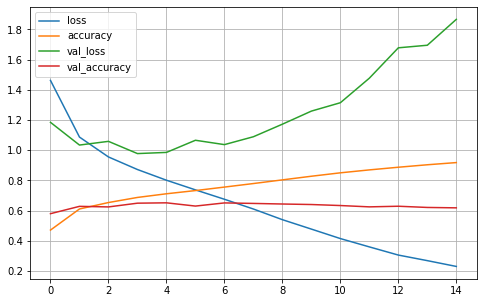

In [59]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [34]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.